## Cytokit Cell Size Analysis

This analysis contains gating and visualization logic for comparing cell sizes from large numbers of microscope images to a dedicated cell counting device ([Thermo Fisher Countess II](https://www.thermofisher.com/us/en/home/life-science/cell-analysis/cell-analysis-instruments/automated-cell-counters/countess-ii-automated-cell-counter.html)).  Samples prepared include both imaging and counting replicates for human primary T cells, Jurkat cells, and mouse PMEL cells.  

## Initialization

In [1]:
library(tidyverse)
library(flowCore)
library(openCyto)
library(ggcyto)
library(repr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: flowWorkspace
Loading required package: ncdfFlow
Loading required package: RcppArmadillo
Loading required package: BH


Visualization defaults and helper functions:

In [2]:
# Default figure size
options(repr.plot.width=8, repr.plot.height=6)

# flowViz defaults for plotGate
flowViz::flowViz.par.set('argcolramp', colorRampPalette(rev(RColorBrewer::brewer.pal(n = 11, name = "Spectral"))))
flowViz::flowViz.par.set('panel.background', list(col='white'))
flowViz::flowViz.par.set('strip.background', list(col='white'))

# ggcyto default theme
flow_theme <- theme(
    panel.grid.minor.x=element_blank(),
    panel.grid.minor.y=element_blank(),
    panel.grid.major.x=element_blank(),
    panel.grid.major.y=element_blank(),
    strip.background=element_rect(colour="white", fill="white")
)

plot_gate <- function(...){
    plotGate(..., scales=list(alternating=F), marker.only=T, xbin=0)
}

Experiment metadata:

In [3]:
# Define experiment names and variants to run analysis for
experiments <- read_csv('experiments.csv', col_types = cols())
variant <- 'v00'
data_dir = '/Volumes/disk1/cytokit/cell-size/20181024'
experiments

exp,stepz,numz,mag,label,type
20181024-d38-act-20X-5by5,1000,29,20x,D38 Activated,Primary T
20181024-d38-unstim-20X-5by5,1000,25,20x,D38 Unstimulated,Primary T
20181024-d39-act-20x-5by5,500,33,20x,D39 Activated,Primary T
20181024-d39-unstim-20x-5by5,500,25,20x,D39 Unstimulated,Primary T
20181024-jurkat-20X-5by5,2000,23,20x,Jurkat R1,Jurkat
20181024-jurkat2-20X-5by5,500,25,20x,Jurkat R2,Jurkat
20181026-pmel-act-20x-5by5,1000,23,20x,Activated PMEL (20x),PMEL
20181026-pmel-act-60x-5b5,500,22,60x,Activated PMEL (60x),PMEL
20181026-pmel-us-20x-5by5,1000,25,20x,Unstimulated PMEL,PMEL


In [4]:
gsm <- experiments %>%
    mutate(path=as.character(str_glue('{data_dir}/{exp}/output/{variant}/cytometry/data.fcs'))) %>%
    as.data.frame %>%
    as('AnnotatedDataFrame')
sampleNames(gsm) <- gsm@data$exp
gsm@data

,exp,stepz,numz,mag,label,type,path
20181024-d38-act-20X-5by5,20181024-d38-act-20X-5by5,1000,29,20x,D38 Activated,Primary T,/Volumes/disk1/cytokit/cell-size/20181024/20181024-d38-act-20X-5by5/output/v00/cytometry/data.fcs
20181024-d38-unstim-20X-5by5,20181024-d38-unstim-20X-5by5,1000,25,20x,D38 Unstimulated,Primary T,/Volumes/disk1/cytokit/cell-size/20181024/20181024-d38-unstim-20X-5by5/output/v00/cytometry/data.fcs
20181024-d39-act-20x-5by5,20181024-d39-act-20x-5by5,500,33,20x,D39 Activated,Primary T,/Volumes/disk1/cytokit/cell-size/20181024/20181024-d39-act-20x-5by5/output/v00/cytometry/data.fcs
20181024-d39-unstim-20x-5by5,20181024-d39-unstim-20x-5by5,500,25,20x,D39 Unstimulated,Primary T,/Volumes/disk1/cytokit/cell-size/20181024/20181024-d39-unstim-20x-5by5/output/v00/cytometry/data.fcs
20181024-jurkat-20X-5by5,20181024-jurkat-20X-5by5,2000,23,20x,Jurkat R1,Jurkat,/Volumes/disk1/cytokit/cell-size/20181024/20181024-jurkat-20X-5by5/output/v00/cytometry/data.fcs
20181024-jurkat2-20X-5by5,20181024-jurkat2-20X-5by5,500,25,20x,Jurkat R2,Jurkat,/Volumes/disk1/cytokit/cell-size/20181024/20181024-jurkat2-20X-5by5/output/v00/cytometry/data.fcs
20181026-pmel-act-20x-5by5,20181026-pmel-act-20x-5by5,1000,23,20x,Activated PMEL (20x),PMEL,/Volumes/disk1/cytokit/cell-size/20181024/20181026-pmel-act-20x-5by5/output/v00/cytometry/data.fcs
20181026-pmel-act-60x-5b5,20181026-pmel-act-60x-5b5,500,22,60x,Activated PMEL (60x),PMEL,/Volumes/disk1/cytokit/cell-size/20181024/20181026-pmel-act-60x-5b5/output/v00/cytometry/data.fcs
20181026-pmel-us-20x-5by5,20181026-pmel-us-20x-5by5,1000,25,20x,Unstimulated PMEL,PMEL,/Volumes/disk1/cytokit/cell-size/20181024/20181026-pmel-us-20x-5by5/output/v00/cytometry/data.fcs


## Data Import

Load all FCS files from imaging experiments into a single flowSet:

In [5]:
fsl <- gsm@data$path %>%
    # Disregard brightfield channels (which are not present in all experiments)
    map(function(p) read.FCS(p, column.pattern='BF', invert.pattern = T)) %>%
    set_names(sampleNames(gsm))
fsr <- flowSet(fsl, phenoData = gsm)
fsr

A flowSet with 9 experiments.

  column names:
  regionindex tileindex tilex tiley rid rx ry id x y z cellsize celldiameter cellperimeter cellcircularity cellsolidity nucleussize nucleusdiameter nucleusperimeter nucleuscircularity nucleussolidity ciDAPI ciMEMB niDAPI niMEMB cgnneighbors cgadjbgpct

In [6]:
# Initialize the GatingSet to apply filters to
gs <- GatingSet(fsr)
markernames(gs) <- fsr@colnames %>% set_names(fsr@colnames)

.........done!


## Gating

As the purpose of this analysis is to infer cell sizes, start by looking at scatter plots of cell vs nucleus diameters as this can often discriminate between poor segmentations resulting from dye aggregation or poor image focus:

Warning message:
“Removed 89 rows containing non-finite values (stat_binhex).”

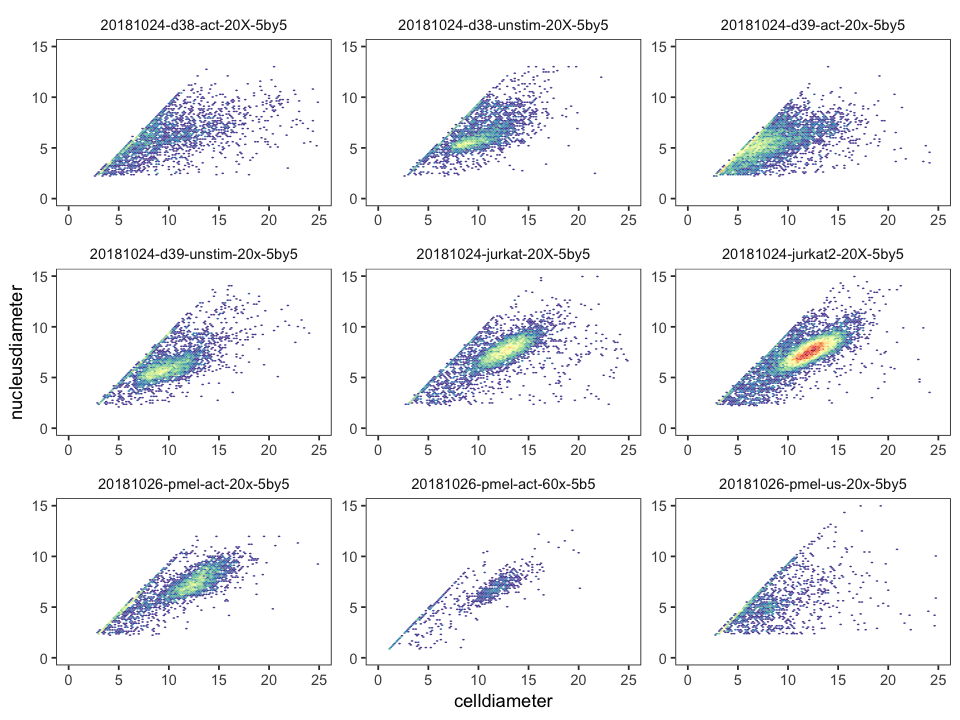

In [7]:
autoplot(getData(gs), 'celldiameter', 'nucleusdiameter', bins=100) + 
    lims(x=c(0, 25), y=c(0, 15)) +
    labs_cyto("marker") +
    theme_bw() + flow_theme

From the above it is clear that a roughly gaussian mixture of cells is present in all experiments along these axes so to proceed, the following gates can be used to eliminate cells based on criteria *NOT* involving cell diameter directly:

In [8]:
add_pop(
  gs, alias="memb", pop="+", parent='root', dims='ciMEMB', 
  gating_method='mindensity', gating_args="gate_range=c(20,150)"
)
add_pop(
  gs, alias="dapi", pop="+", parent='memb', dims='niDAPI', 
  gating_method='tailgate', gating_args="side='left',tol=1e-6,max=225"
)
add_pop(
  gs, alias="circularity", pop="+", parent='dapi', dims='cellcircularity,nucleuscircularity', 
  gating_method='flowClust.2d', gating_args="K=1"
)
add_pop(
  gs, alias="cells", pop="+", parent='circularity', dims='celldiameter,nucleusdiameter', 
  gating_method='flowClust.2d', gating_args="K=1,quantile=.95"
)


...
done
...
done
...
done
...
done


#### Gate Visualization

Each of the above gating strategies was chosen to eliminate some portion of cells found in images to be unwanted (via Explorer).  The results of each step are shown below with the final gate indicating a removal of more obvious outliers on the cell vs nucleus axes:

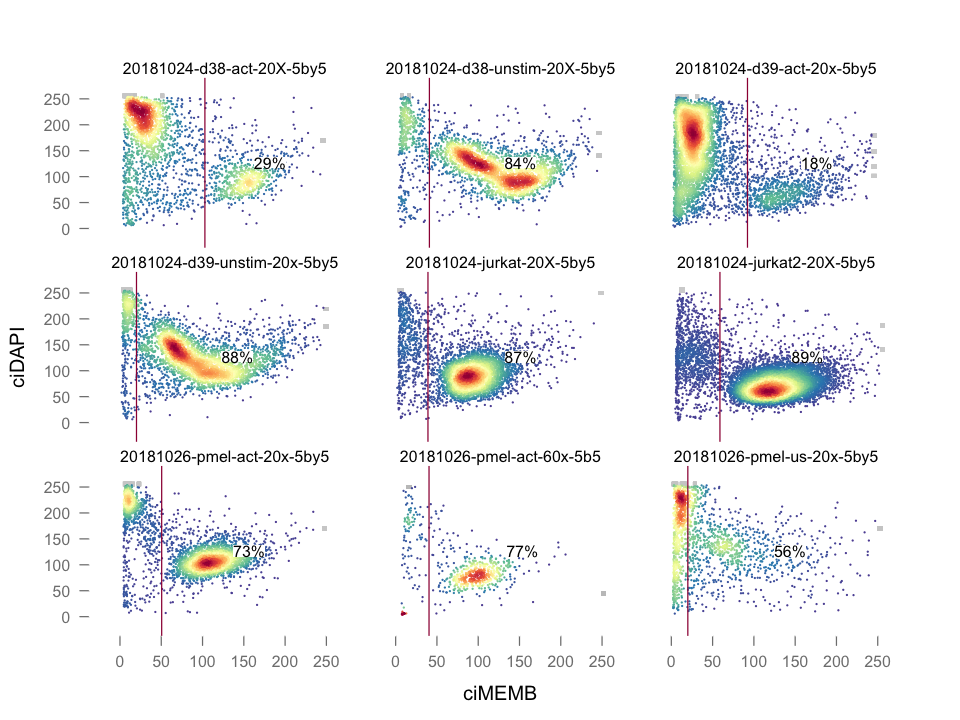

In [9]:
plot_gate(gs, 'memb', default.y='ciDAPI')

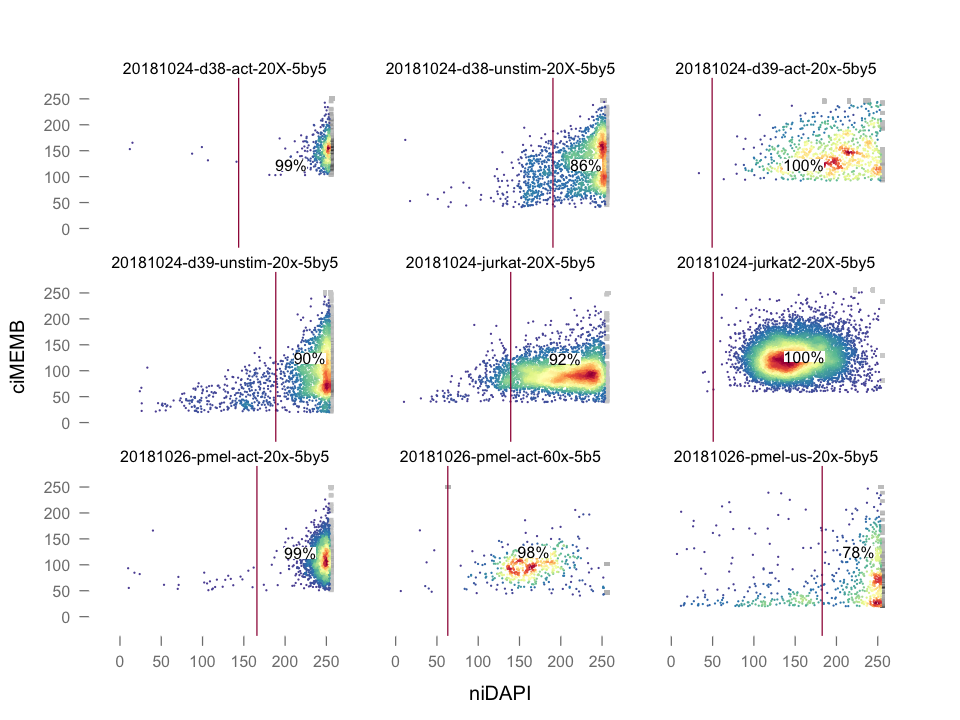

In [10]:
plot_gate(gs, 'dapi', default.y='ciMEMB')

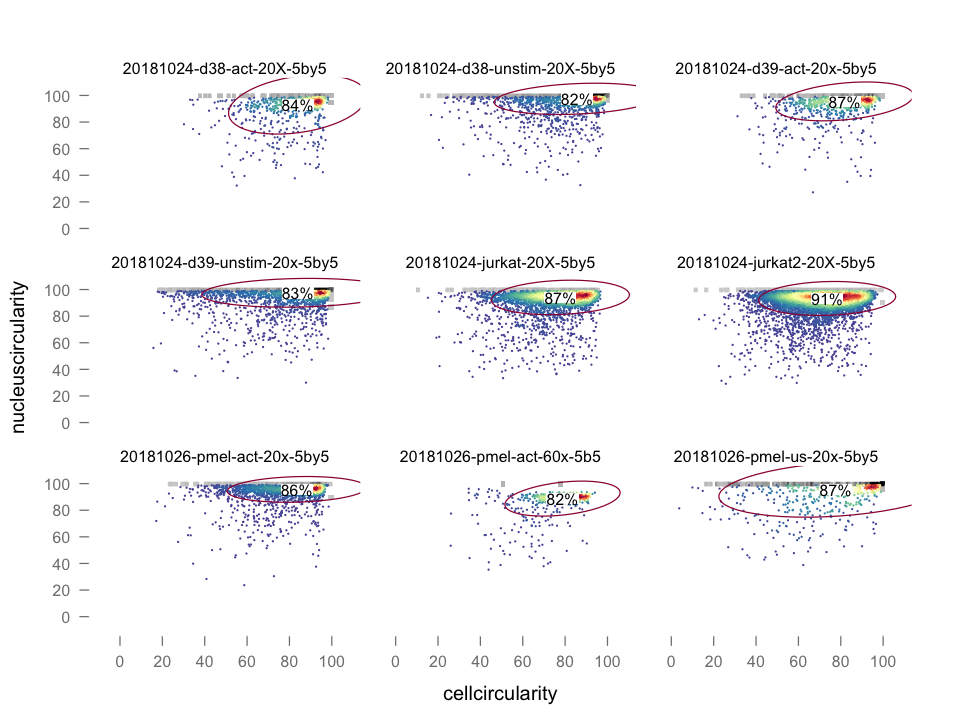

In [11]:
plot_gate(gs, 'circularity')

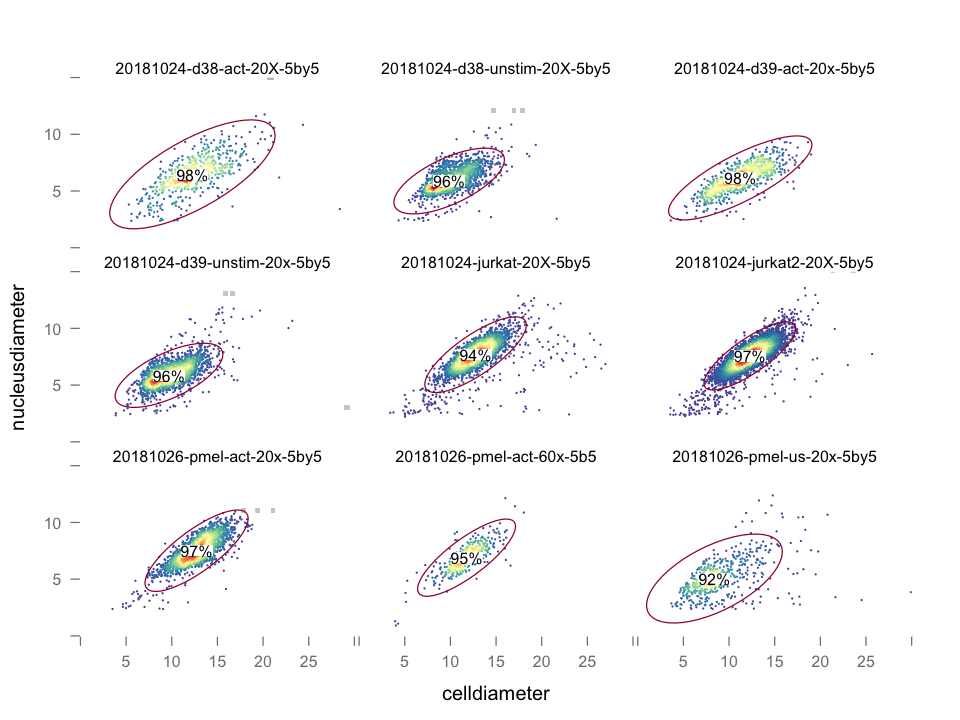

In [12]:
plot_gate(gs, 'cells', xlim=c(0, 30), ylim=c(0, 15))

## Results

Revisiting the initial issue then, we can see below that the resulting cell population is much cleaner and more likely to represent the distribution of natural morphological differences in these cells:

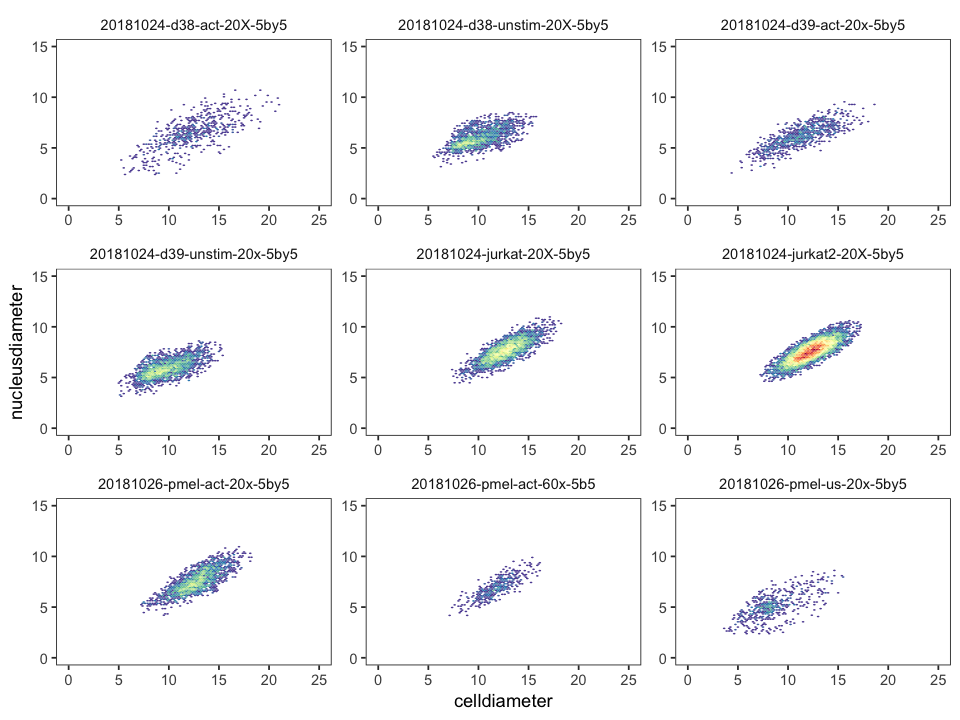

In [13]:
autoplot(getData(gs, 'cells'), 'celldiameter', 'nucleusdiameter', bins=100) + 
    lims(x=c(0, 25), y=c(0, 15)) +
    labs_cyto("marker") +
    theme_bw() + 
    flow_theme

To compare the cleaned results to results from a cell counter, first extract the relevant flowCore data as a data frame:

In [14]:
extract_df <- function(gs, pop){
    sampleNames(gs) %>% 
        map(function(n) getData(gs, pop)[[n]] %>% exprs %>% as.tibble %>% mutate(exp=n)) %>%
        bind_rows %>%
        mutate(replicate=case_when(
            exp == '20181024-jurkat2-20X-5by5' ~ 'R2', 
            TRUE ~ 'R1'
        ))
}
df_ck <- extract_df(gs, 'cells')
        
df_ck %>% select(id, exp, replicate, celldiameter) %>% sample_n(6)

id,exp,replicate,celldiameter
28,20181024-d39-act-20x-5by5,R1,11.187417
291,20181024-jurkat2-20X-5by5,R2,12.240392
43,20181024-d39-act-20x-5by5,R1,15.219512
72,20181024-jurkat2-20X-5by5,R2,9.054709
97,20181024-jurkat2-20X-5by5,R2,12.365710
178,20181024-jurkat-20X-5by5,R1,11.073339


Load the cell counter results exported as a csv:

In [15]:
df_ct <- read_csv('cell_counter_results.csv', col_types = cols())
df_ct

file,donor,state,replicate,concentration,livepct,value,exp
20181023-d38-act1.tiff,Donor 38,Activated (7 days),R1,2050000,0.39,11.38,20181024-d38-act-20X-5by5
20181023-d38-act2.tiff,Donor 38,Activated (7 days),R2,2240000,0.32,11.49,20181024-d38-act-20X-5by5
20181023-d38-unstim1.tiff,Donor 38,Unstimulated,R1,3200000,0.80,10.18,20181024-d38-unstim-20X-5by5
20181023-d38-unstim2.tiff,Donor 38,Unstimulated,R2,3740000,0.80,10.22,20181024-d38-unstim-20X-5by5
20181023-d39-act1.tiff,Donor 39,Activated (7 days),R1,2830000,0.30,9.95,20181024-d39-act-20x-5by5
20181023-d39-act2.tiff,Donor 39,Activated (7 days),R2,3520000,0.34,10.45,20181024-d39-act-20x-5by5
20181023-d39-us1.tiff,Donor 39,Unstimulated,R1,4290000,0.85,10.60,20181024-d39-unstim-20x-5by5
20181023-d39-us2.tiff,Donor 39,Unstimulated,R2,4290000,0.82,10.27,20181024-d39-unstim-20x-5by5
20181023-jurkat1.tiff,Jurkat,Unstimulated,R1,809000,0.91,14.48,20181024-jurkat-20X-5by5
20181023-jurkat2.tiff,Jurkat,Unstimulated,R2,727000,0.94,14.40,20181024-jurkat-20X-5by5


Visualize the cell diameter distributions from the microscope vs the counter across the different replicates and cell types:

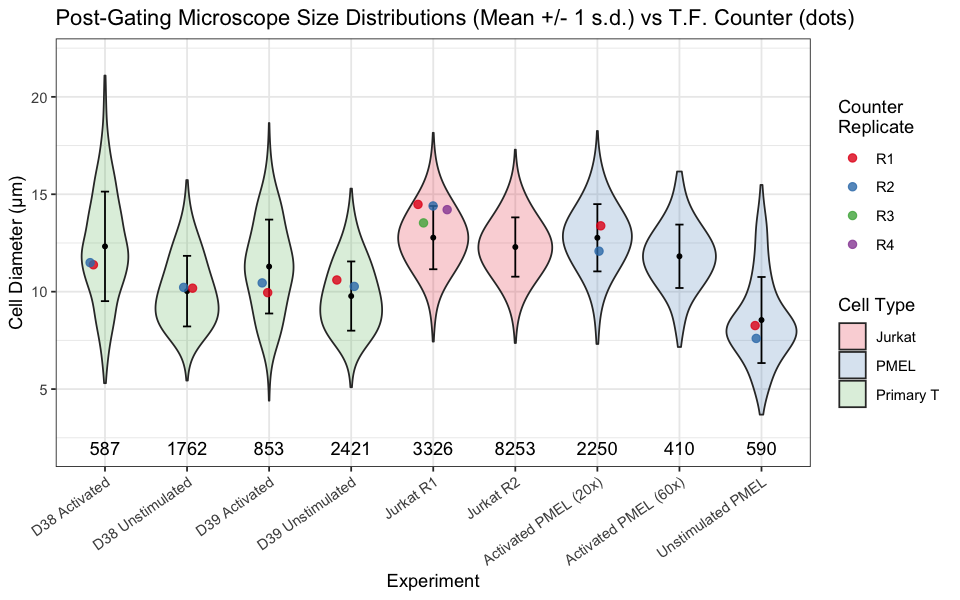

In [16]:
options(repr.plot.width=8, repr.plot.height=5)

plot_size_distribution <- function(df_ck, df_ct){
    set.seed(2)
    
    df_err <- df_ck %>% group_by(exp, replicate) %>% summarize(
            mid=mean(celldiameter),
            lo=mean(celldiameter) - sd(celldiameter),
            hi=mean(celldiameter) + sd(celldiameter)
        ) %>% ungroup
    
    ggplot(NULL) +
        geom_violin(
            data=df_ck %>% inner_join(experiments %>% select(exp, type), by='exp'), 
            aes(x=exp, y=celldiameter, fill=type), 
            alpha=.2,
            bw=.75
        ) + 
        geom_errorbar(
            data=df_err,
            aes(x=exp, ymin=lo, ymax=hi),
            width=.1
        ) +
        geom_point(
            data=df_err,
            aes(x=exp, y=mid),
            size=1
        ) +
        geom_jitter(
            data=df_ct,
            aes(x=exp, y=value, group=replicate, color=replicate),
            width=.2,
            height=0,
            alpha=.8,
            size=2
        ) +
        geom_text(
            data=df_ck %>% group_by(exp) %>% tally %>% ungroup %>% mutate(n=as.character(n)),
            aes(x=exp, y=2, label=n),
            position=position_dodge(width=.9)
        ) +
        scale_x_discrete(labels=experiments$label %>% set_names(experiments$exp)) +
        scale_fill_brewer(palette = 'Set1') +
        scale_color_brewer(palette = 'Set1') +
        labs(
            fill='Cell Type', 
            color='Counter\nReplicate', 
            x='Experiment',
            y='Cell Diameter (µm)'
        ) +
        ylim(2, 22) +
        theme_bw() +
        theme(
            axis.text.x = element_text(angle = 35, hjust = 1)
        )
}
plot_size_distribution(df_ck, df_ct) + 
    ggtitle('Post-Gating Microscope Size Distributions (Mean +/- 1 s.d.) vs T.F. Counter (dots)')

In [17]:
Lastly, generate the same visualization with no gating to show how the distributions were altered:

ERROR: Error in parse(text = x, srcfile = src): <text>:1:7: unexpected ','
1: Lastly,
          ^


.........done!
Warning message:
“Removed 184 rows containing non-finite values (stat_ydensity).”

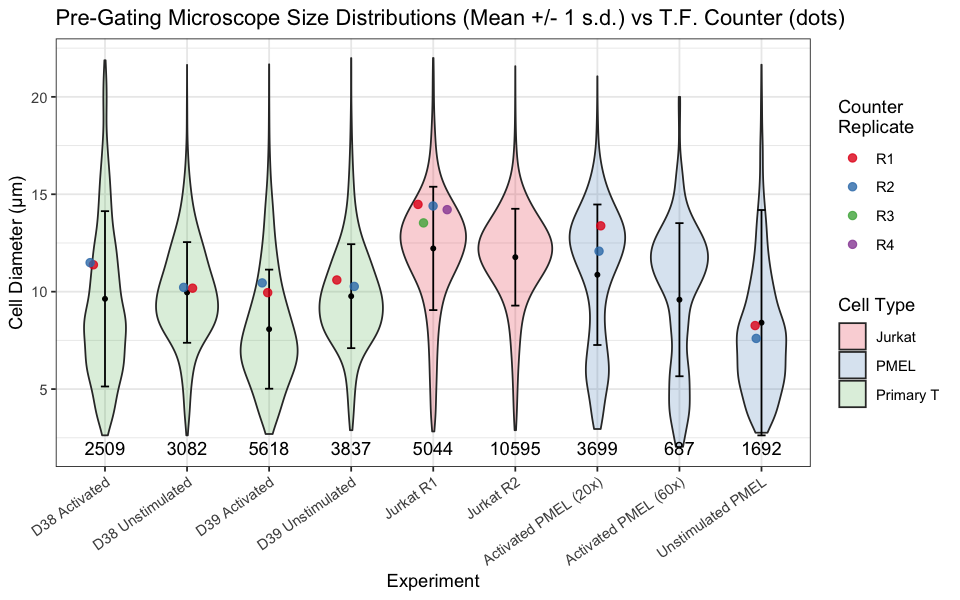

In [18]:
gs_nf <- GatingSet(fsr)
markernames(gs_nf) <- fsr@colnames %>% set_names(fsr@colnames)
df_ck_nf <- extract_df(gs_nf, 'root')
plot_size_distribution(df_ck_nf, df_ct) + 
    ggtitle('Pre-Gating Microscope Size Distributions (Mean +/- 1 s.d.) vs T.F. Counter (dots)')

----

Environment:

In [19]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS High Sierra 10.13.3

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] hexbin_1.27.2             bindrcpp_0.2.2           
 [3] repr_0.18                 ggcyto_1.10.0            
 [5] openCyto_1.20.0           flowWorkspace_3.30.0     
 [7] ncdfFlow_2.28.0           BH_1.66.0-1              
 [9] RcppArmadillo_0.9.200.4.0 flowCore_1.48.0          
[11] forcats_0.3.0             stringr_1.3.1            
[13] dplyr_0.7.8               purrr_0.2.5              
[15] readr_1.1.1               tidyr_0.8.2              
[17] tibble_1.4.2      